In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from wangsheng_utils import *

In [2]:
# helper functions
# first we define functions we need
# haversine distance function
from math import radians, cos, sin, asin, sqrt
def haversine(lat1, long1, lat2, long2):
    """
Code Ref.: https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

# find the nmber of nearest infrastructure to our property listing
# km is the maximum distance we want to calculate from. 
# calculate the number of infrastructure within x km
def count_nearest(lat, long, infrastructure, km):
    distances = infrastructure.apply(
        lambda row: haversine(lat, long, row['lat'], row['lng']), 
        axis=1)
    
    return sum(i <= km for i in distances)


# find the distance of the nearest infrastructure to our property listing
def find_nearest_distance(lat, long, infrastructure):
    distances = infrastructure.apply(
        lambda row: haversine(lat, long, row['lat'], row['lng']), 
        axis=1)
    return distances.min()


# get the population of the subzone the listing is in
def find_subzone_population(subzone, subzones_df):
    sz = subzones_df
    if subzone == "":
        sz_pop = None
    else:
        sz_pop = sz.loc[sz['name'] == subzone, 'population'].item()
    return sz_pop

# get the population density of the subzone the listing is in
def find_subzone_population_density(subzone, subzones_df):
    sz = subzones_df
    if subzone == "":
        sz_pop_density = None
    else:
        sz_pop_density = sz.loc[sz['name'] == subzone, 'population'].item()/sz.loc[sz['name'] == subzone, 'area_size'].item()
    return sz_pop_density

def improve_dataset(df):
    df = df.copy()
    # get the files containing the infrastructures data
    cc = pd.read_csv("data/auxiliary-data/sg-commerical-centres.csv")
    mrt = pd.read_csv("data/auxiliary-data/sg-mrt-stations.csv")
    ps = pd.read_csv("data/auxiliary-data/sg-primary-schools.csv")
    ss = pd.read_csv("data/auxiliary-data/sg-secondary-schools.csv")
    sm = pd.read_csv("data/auxiliary-data/sg-shopping-malls.csv")
    sz = pd.read_csv("data/auxiliary-data/sg-subzones.csv")
    
    df.subzone = df.subzone.fillna('') 
    
    # get the population of the subzone the listing is in, and add to data
    df['subzone_pop'] = df.apply(
        lambda row: find_subzone_population(row['subzone'], sz), 
        axis=1)
    df['subzone_pop'] = df['subzone_pop'].round(decimals=3)
    
    # get the population of the subzone the listing is in, and add to data
    df['subzone_pop_density'] = df.apply(
        lambda row: find_subzone_population(row['subzone'], sz), 
        axis=1)
    df['subzone_pop_density'] = df['subzone_pop_density'].round(decimals=3)
    
    # calculate distance to nearest commercial center
    df['dist_2_nearest_cc'] = df.apply(
        lambda row: find_nearest_distance(row['lat'], row['lng'], cc), 
        axis=1)
    df['dist_2_nearest_cc'] = df['dist_2_nearest_cc'].round(decimals=3)

    # calculate the number of commercial centers within x km
    df['nearest_cc_count'] = df.apply(
        lambda row: count_nearest(row['lat'], row['lng'], cc, 1), 
        axis=1)
    
    # calculate distance to nearest mrt station
    df['dist_2_nearest_mrt'] = df.apply(
        lambda row: find_nearest_distance(row['lat'], row['lng'], mrt), 
        axis=1)
    df['dist_2_nearest_mrt'] = df['dist_2_nearest_mrt'].round(decimals=3)

    # calculate the number of mrt stations within x km
    df['nearest_mrt_count'] = df.apply(
        lambda row: count_nearest(row['lat'], row['lng'], mrt, 1), 
        axis=1)
    
    # calculate distance to nearest primary school
    df['dist_2_nearest_ps'] = df.apply(
        lambda row: find_nearest_distance(row['lat'], row['lng'], ps), 
        axis=1)
    df['dist_2_nearest_ps'] = df['dist_2_nearest_ps'].round(decimals=3)

    # calculate the number of primary schools within x km
    df['nearest_ps_count'] = df.apply(
        lambda row: count_nearest(row['lat'], row['lng'], ps, 1), 
        axis=1)
    # calculate distance to nearest secondary school
    df['dist_2_nearest_ss'] = df.apply(
        lambda row: find_nearest_distance(row['lat'], row['lng'], ss), 
        axis=1)
    df['dist_2_nearest_ss'] = df['dist_2_nearest_ss'].round(decimals=3)

    # calculate the number of secondary schools within x km
    df['nearest_ss_count'] = df.apply(
        lambda row: count_nearest(row['lat'], row['lng'], ss, 1), 
        axis=1)
    
    # calculate distance to nearest shopping mall
    df['dist_2_nearest_sm'] = df.apply(
        lambda row: find_nearest_distance(row['lat'], row['lng'], sm), 
        axis=1)
    df['dist_2_nearest_sm'] = df['dist_2_nearest_sm'].round(decimals=3)

    # calculate the number of secondary schools within x km
    df['nearest_sm_count'] = df.apply(
        lambda row: count_nearest(row['lat'], row['lng'], sm, 1), 
        axis=1)

    return df

In [3]:
def handle_missing_values(df) -> pd.DataFrame:
    df = df.copy()
    # Treat missing year data as new.
    # Semantically, we define this attribute as the depreciation factor for pricing.
    # A new house or one with missing data denotes the depreciation factor is 0 or unknown.
    # The depreciation factor is assumed to be the difference between construction and current year.
    # TODO: Maybe do not treat future years as current! Inflation factor might be one to look out for.
    df['built_year'] = df['built_year'].fillna(2022)
    
    # TODO: 80 are missing. Should we remove them or should we keep it as 0?
    # Verify assumption if studio qualifies as 1 bed. 
    # 75 of missing are studio, we replace the Nan as 1
    filter_beds_studio = ((df.num_beds.isna()) & ((df.title.str.contains('studio','Studio', flags=re.IGNORECASE, regex=True))))
    df.loc[filter_beds_studio, "num_beds"] = 1
    
    ## HDB
    ## bathrooms
    ## Fill missing data for HDB, bathrooms
         
    ## Fill bathroom = 1 For HDB size 2-room
    df.loc[(df['num_beds'] <= 2) & (df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) & (df.num_baths.isna()), "num_baths"] = 1
    ## Fill bathroom = 2 For HDB size 3-room, 4-room, 5-room
    df.loc[(df['num_beds'] < 4) & (df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) & (df.num_baths.isna()), "num_baths"] = 2
    ## Fill bathroom = 3 For HDB Executive and Mansionette
    df.loc[(df['num_beds'] == 4) & (df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) & (df.num_baths.isna()), "num_baths"] = 3
    ## Fill bathroom = 4 For HDB jumbo
    df.loc[(df['num_beds'] > 4) & (df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) & (df.num_baths.isna()), "num_baths"] = 4


    ## If number of beds are missing, then we use size as a gauge

    ## Fill bathroom = 1 For HDB size 500 sq ft and below
    df.loc[(df['size_sqft'] <= 500) & (df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) & (df.num_baths.isna()), "num_baths"] = 1
    ## Fill bathroom = 2 For HDB size 1500 sq ft and below
    df.loc[(df['size_sqft'] <= 1500) & (df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) & (df.num_baths.isna()), "num_baths"] = 2
    ## Fill bathroom = 3 For HDB size between 1500 sq ft and 2000 sq ft
    df.loc[(df['size_sqft'] > 1500) & (df['size_sqft'] <= 2000) & (df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) & (df.num_baths.isna()), "num_baths"] = 3
    ## Fill bathroom = 4 For HDB size between 2000 sq ft and 2500 sq ft
    df.loc[(df['size_sqft'] > 2000) & (df['size_sqft'] <= 2500) & (df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) & (df.num_baths.isna()), "num_baths"] = 4
    
    
    ## HDB
    ## bedrooms
    ## Fill missing data for HDB, bedrooms

    ## Fill bedrooms = 1 For HDB size 500 sq ft and below
    df.loc[(df['num_baths'] == 1) & (df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) & (df.num_beds.isna()), "num_beds"] = 2
    ## Fill bedrooms = 2 For HDB size 3-room, 4-room, 5-room
    df.loc[(df['num_baths'] == 2) & (df['size_sqft'] <= 800) &(df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) & (df.num_beds.isna()), "num_beds"] = 2
    ## Fill bedrooms = 3 For HDB Executive and Mansionette
    df.loc[(df['num_baths'] == 2) & (df['size_sqft'] <= 1200) & (df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) & (df.num_beds.isna()), "num_beds"] = 3
    ## Fill bedrooms = 3 For HDB jumbo
    df.loc[(df['num_baths'] >= 2) & (df['size_sqft'] <= 1500) & (df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) & (df.num_beds.isna()), "num_beds"] = 4
    ## Fill bedrooms = 4 For HDB jumbo
    df.loc[(df['num_baths'] > 2) & (df['size_sqft'] <= 2000) & (df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) & (df.num_beds.isna()), "num_beds"] = 4
    ## Fill bedrooms = 5 For HDB jumbo
    df.loc[(df['num_baths'] > 3) & (df['size_sqft'] <= 2200) & (df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) & (df.num_beds.isna()), "num_beds"] = 5
    ## Fill bedrooms = 6 For HDB jumbo
    df.loc[(df['num_baths'] > 3) & (df['size_sqft'] <= 2500) & (df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) & (df.num_beds.isna()), "num_beds"] = 6

    ## If number of baths are missing, then we use size as a gauge

    ## Fill bedrooms = 2 For HDB size 3-room, 4-room, 5-room
    df.loc[(df['size_sqft'] <= 800) &(df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) & (df.num_beds.isna()), "num_beds"] = 2
    ## Fill bedrooms = 3 For HDB Executive and Mansionette
    df.loc[(df['size_sqft'] <= 1200) & (df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) & (df.num_beds.isna()), "num_beds"] = 3
    ## Fill bedrooms = 3 For HDB jumbo
    df.loc[(df['size_sqft'] <= 1500) & (df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) & (df.num_beds.isna()), "num_beds"] = 4
    ## Fill bedrooms = 4 For HDB jumbo
    df.loc[(df['size_sqft'] <= 2000) & (df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) & (df.num_beds.isna()), "num_beds"] = 4
    ## Fill bedrooms = 5 For HDB jumbo
    df.loc[(df['size_sqft'] <= 2200) & (df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) & (df.num_beds.isna()), "num_beds"] = 5
    ## Fill bedrooms = 6 For HDB jumbo
    df.loc[(df['size_sqft'] <= 2500) & (df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) & (df.num_beds.isna()), "num_beds"] = 6
 
    ## Condos
    ## bathrooms
    ## Fill missing data for condos,apartments bathrooms
         
    ## Fill bathroom = 1 For Condo, apartment size 2-room
    df.loc[(df['num_beds'] <= 2) & ((df.property_type.str.contains('condo','Condo', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('apart','Apart', flags=re.IGNORECASE, regex=False))) & (df.num_baths.isna()), "num_baths"] = 1
    ## Fill bathroom = 2 For Condo, apartment size 2-room size 3-room, 4-room, 5-room
    df.loc[(df['num_beds'] <= 4) & ((df.property_type.str.contains('condo','Condo', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('apart','Apart', flags=re.IGNORECASE, regex=False))) & (df.num_baths.isna()), "num_baths"] = 2
    ## Fill bathroom = 3 For Condo Executive
    df.loc[(df['num_beds'] <= 5) & ((df.property_type.str.contains('condo','Condo', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('apart','Apart', flags=re.IGNORECASE, regex=False))) & (df.num_baths.isna()), "num_baths"] = 3
    ## Fill bathroom = 4 For Huge Condos
    df.loc[(df['num_beds'] > 5) & ((df.property_type.str.contains('condo','Condo', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('apart','Apart', flags=re.IGNORECASE, regex=False))) & (df.num_baths.isna()), "num_baths"] = 4


    ## If number of beds are missing, then we use size as a gauge

    ## Fill bathroom = 1 For Condos less than 800 sq ft
    df.loc[(df['size_sqft'] <= 800) & ((df.property_type.str.contains('condo','Condo', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('apart','Apart', flags=re.IGNORECASE, regex=False))) & (df.num_baths.isna()), "num_baths"] = 1
    ## Fill bathroom = 2 For Condos between 800 sq ft and 1300 sq ft
    df.loc[(df['size_sqft'] <= 1300) & ((df.property_type.str.contains('condo','Condo', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('apart','Apart', flags=re.IGNORECASE, regex=False))) & (df.num_baths.isna()), "num_baths"] = 2
    ## Fill bathroom = 3 For Condos between 1300 sq ft and 1600 sq ft
    df.loc[(df['size_sqft'] <= 1600) & ((df.property_type.str.contains('condo','Condo', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('apart','Apart', flags=re.IGNORECASE, regex=False))) & (df.num_baths.isna()), "num_baths"] = 3
    ## Fill bathroom = 4 For Huge Condos
    df.loc[(df['size_sqft'] > 1600) & ((df.property_type.str.contains('condo','Condo', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('apart','Apart', flags=re.IGNORECASE, regex=False))) & (df.num_baths.isna()), "num_baths"] = 4
    
    ## Condos
    ## bedrooms
    
    ## Fill bedrooms = 2  For Condos between 800 sq ft and 1300 sq ft
    df.loc[(df['size_sqft'] <= 800) & ((df.property_type.str.contains('condo','Condo', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('apart','Apart', flags=re.IGNORECASE, regex=False))) & (df.num_beds.isna()), "num_beds"] = 2
    ## Fill bedrooms = 3  For Condos between 850 sq ft and 1250 sq ft
    df.loc[(df['size_sqft'] <= 1250) & ((df.property_type.str.contains('condo','Condo', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('apart','Apart', flags=re.IGNORECASE, regex=False))) & (df.num_beds.isna()), "num_beds"] = 3
    ## Fill bedrooms = 4  For Condos between 1250 sq ft and 1500 sq ft
    df.loc[(df['size_sqft'] <= 1500) & ((df.property_type.str.contains('condo','Condo', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('apart','Apart', flags=re.IGNORECASE, regex=False))) & (df.num_beds.isna()), "num_beds"] = 4
    ## Fill bedrooms = 5  For Condos more than 1500 sq ft
    df.loc[(df['size_sqft'] > 1500) & ((df.property_type.str.contains('condo','Condo', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('apart','Apart', flags=re.IGNORECASE, regex=False))) & (df.num_beds.isna()), "num_beds"] = 5
    
    ## All other houses
    ## bedrooms
    
    ## Fill bedrooms = 2  For houses between 800 sq ft and 1300 sq ft
    df.loc[(df['size_sqft'] <= 800) & (~((df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('condo','Condo', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('apart','Apart', flags=re.IGNORECASE, regex=False)))) & (df.num_beds.isna()), "num_beds"] = 2
    ## Fill bedrooms = 3  For houses between 850 sq ft and 1250 sq ft
    df.loc[(df['size_sqft'] <= 1250) & (~((df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('condo','Condo', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('apart','Apart', flags=re.IGNORECASE, regex=False)))) & (df.num_beds.isna()), "num_beds"] = 3
    ## Fill bedrooms = 4  For houses between 1250 sq ft and 1500 sq ft
    df.loc[(df['size_sqft'] <= 1500) & (~((df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('condo','Condo', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('apart','Apart', flags=re.IGNORECASE, regex=False)))) & (df.num_beds.isna()), "num_beds"] = 4
    ## Fill bedrooms = 5  For houses more than 1500 sq ft
    df.loc[(df['size_sqft'] > 1500) & (~((df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('condo','Condo', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('apart','Apart', flags=re.IGNORECASE, regex=False)))) & (df.num_beds.isna()), "num_beds"] = 5
    
    ## All other houses
    ## bathrooms
    
    ## Fill bathrooms = 1  For houses with 1 bed
    df.loc[(df['num_beds'] == 1) & (~((df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('condo','Condo', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('apart','Apart', flags=re.IGNORECASE, regex=False)))) & (df.num_baths.isna()), "num_baths"] = 1
    ## Fill bathrooms = 2  For houses with 2 beds
    df.loc[(df['num_beds'] == 2) & (~((df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('condo','Condo', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('apart','Apart', flags=re.IGNORECASE, regex=False)))) & (df.num_baths.isna()), "num_baths"] = 2
    ## Fill bedrooms = 2  For houses with 3 beds
    df.loc[(df['num_beds'] == 3 ) & (~((df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('condo','Condo', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('apart','Apart', flags=re.IGNORECASE, regex=False)))) & (df.num_baths.isna()), "num_baths"] = 2
    ## Fill bedrooms = 3  For houses with 4 beds
    df.loc[(df['num_beds'] == 4) & (~((df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('condo','Condo', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('apart','Apart', flags=re.IGNORECASE, regex=False)))) & (df.num_baths.isna()), "num_baths"] = 3
    ## Fill bedrooms = 4  For houses with 5 or more beds
    df.loc[(df['num_beds'] > 4) & (~((df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('condo','Condo', flags=re.IGNORECASE, regex=False)) | (df.property_type.str.contains('apart','Apart', flags=re.IGNORECASE, regex=False)))) & (df.num_baths.isna()), "num_baths"] = 4
    
    # TODO: Filling with 0 for test data. Some imputation might be better.
    df['num_beds'] = df['num_beds'].fillna(0)
    df['num_baths'] = df['num_baths'].fillna(0)
                
    # Handle missing coordinates data
    for idx in df.index:
        if pd.isnull(df.at[idx, 'lat']) or pd.isnull(df.at[idx, 'lng']) or pd.isnull(df.at[idx, 'subzone']):
            lat, lng = find_lat_lng(df.at[idx, 'address'])
            if lat is not None:
                df.at[idx, 'lat'] = float(lat)
                #print("Fixed address {} with latitude: {}".format(df.at[idx, 'address'], df.at[idx, 'lat']))
            if lng is not None:
                df.at[idx, 'lng'] = float(lng)
                #print("Fixed address {} with longitude: {}".format(df.at[idx, 'address'], df.at[idx, 'lng']))
    
    return df

In [4]:
def remove_invalid_values(df) -> pd.DataFrame:
    df = df.copy()
    # Price is the target regression variable. If negative or 0, treat that row as invalid (logical assumption)
    if 'price' in df:
        df = df[df.price > 0]

    # Filter out HDB prices more than 2,000,000 (real-world knowledge; ref. source)
    if 'price' in df:
        filter_price_hdb = ((df.price > 2000000) & ((df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=True)) | (df.title.str.contains('hdb','Hdb', regex=False))))
        df_dropped = df[filter_price_hdb]
        df = df.drop(df[filter_price_hdb].index)
        
    # Filter out HDB with more bathrooms than bedrooms (real-world knowledge; ref. source)
    filter_bath_beds_hdb = ((df.num_baths > df.num_beds) & ((df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=True)) | (df.title.str.contains('hdb','Hdb', regex=False))))
    df_dropped = df[filter_bath_beds_hdb]
    df = df.drop(df[filter_bath_beds_hdb].index)

    # Filter out HDB with more than 4 bathrooms or 6 bedrooms (real-world knowledge; ref. source)
    filter_bath_beds_4_hdb = (((df.num_baths > 4) | (df.num_beds > 6)) & ((df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=True)) | (df.title.str.contains('hdb','Hdb', regex=False))))
    df_dropped = df[filter_bath_beds_4_hdb]
    df = df.drop(df[filter_bath_beds_4_hdb].index)
    
    return df

In [5]:
def remove_outliers(df) -> pd.DataFrame:
    df = df.copy()
    # Filter out HDB with size > 2500 sqft (outlier detection)
    filter_size_hdb = ((df.size_sqft > 2500) & ((df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=True)) | (df.title.str.contains('hdb','Hdb', regex=False))))
    df[filter_size_hdb][['property_type','num_baths','num_beds','size_sqft','price']]
    df_dropped = df[filter_size_hdb]
    df = df.drop(df[filter_size_hdb].index)
    
    # Target label is used below for outlier detection. Appropriately tagged data is dropped entirely.
    if 'price' in df:
    # Filtering those data with less than $200/square feet
        df['price per sq ft'] = df['price']/df['size_sqft']
        filter_price_sqft_200 = ((df['price per sq ft'] < 200) & (df['price per sq ft'] > 0))
        df_dropped = df[filter_price_sqft_200]
        df = df.drop(df[filter_price_sqft_200].index)
    # Filtering those data with less than 500 square feet, and more than $5000 per square feet
        df['price per sq ft'] = df['price']/df['size_sqft']
        filter_size = ((df['price per sq ft'] > 5000) & (df['price per sq ft'] > 0) & (df['size_sqft'] < 500))
        df_dropped = df[filter_size]
        df = df.drop(df[filter_size].index)
    # Filter out HDB more than $1600 per square feet and since last sold highest price for hdb is $1400
        df['price per sq ft'] = df['price']/df['size_sqft']
        filter_price_hdb_2 = ( (df['price per sq ft']>1600) & ((df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=True)) | (df.title.str.contains('hdb','Hdb', regex=False))))
        
        df_dropped = df[filter_price_hdb_2]
        df = df.drop(df[filter_price_hdb_2].index)
           
        df.drop('price per sq ft', axis=1, inplace=True)
    
    return df

In [6]:
def transform_data(df) -> pd.DataFrame:
    df = df.copy()
    # TODO: Test against not doing this.
    df.loc[df["built_year"] > 2022, "built_year"] = 2022
    
    # Convert built_year into the aforementioned depreciation factor
    df["depreciation"] = (2022-df["built_year"])
    
    # TODO: Add details on why we are doing so
    df.loc[df.property_type.str.contains('hdb', flags=re.IGNORECASE, regex=True), 'property_type'] = 'hdb'
    df.loc[df.property_type.str.contains('condo', flags=re.IGNORECASE, regex=True), 'property_type'] = 'condo'
    df['property_type'] = df['property_type'].str.lower()
    df.loc[df.property_type.str.contains('cluster house', flags=re.IGNORECASE, regex=True), 'property_type'] = 'landed'
    df.loc[df.property_type.str.contains('townhouse', flags=re.IGNORECASE, regex=True), 'property_type'] = 'landed'
    df.loc[df.property_type.str.contains('land only', flags=re.IGNORECASE, regex=True), 'property_type'] = 'landed'
    df.loc[df.property_type.str.contains('apartment',  flags=re.IGNORECASE, regex=True), 'property_type'] = 'condo'
    df.loc[df.property_type.str.contains('bungalow', flags=re.IGNORECASE, regex=True), 'property_type'] = 'bungalow'
    df.loc[df.property_type.str.contains('semi-detached house', flags=re.IGNORECASE, regex=True), 'property_type'] = 'corner'
    df.loc[df.property_type.str.contains('corner terrace',flags=re.IGNORECASE, regex=True), 'property_type'] = 'corner'
    df.loc[df.property_type.str.contains('shophouse', flags=re.IGNORECASE, regex=True), 'property_type'] = 'protected'
    df.loc[df.property_type.str.contains('conservation house', flags=re.IGNORECASE, regex=True), 'property_type'] = 'protected'
    # Get one hot encoding of columns property_type
    property_columns = ['bungalow', 'condo', 'hdb', 'corner', 'landed', 'protected', 'terraced house', 'walk-up']
    one_hot = pd.get_dummies(df['property_type'], columns=property_columns)
    # Join the encoded df
    df = df.join(one_hot)
    
    df['tenure'] = df['tenure'].fillna(value=df.property_type)
    df.loc[df.tenure.str.contains('hdb', flags=re.IGNORECASE, regex=True), 'tenure'] = '99-year leasehold'
    df.loc[df.tenure.str.contains('condo', flags=re.IGNORECASE, regex=True), 'tenure'] = '99-year leasehold'
    df.loc[df.tenure.str.contains('terraced house', flags=re.IGNORECASE, regex=True), 'tenure'] = '99-year leasehold'
    df.loc[df.tenure.str.contains('corner', flags=re.IGNORECASE, regex=True), 'tenure'] = '99-year leasehold'
    df.loc[df.tenure.str.contains('landed', flags=re.IGNORECASE, regex=True), 'tenure'] = '99-year leasehold'
    df.loc[df.tenure.str.contains('protected', flags=re.IGNORECASE, regex=True), 'tenure'] = 'freehold'
    df.loc[df.tenure.str.contains('bungalow', flags=re.IGNORECASE, regex=True), 'tenure'] = 'freehold'
    df.loc[df.tenure.str.contains('110-year leasehold', flags=re.IGNORECASE, regex=True), 'tenure'] = '99-year leasehold'
    df.loc[df.tenure.str.contains('103-year leasehold', flags=re.IGNORECASE, regex=True), 'tenure'] = '99-year leasehold'
    df.loc[df.tenure.str.contains('102-year leasehold', flags=re.IGNORECASE, regex=True), 'tenure'] = '99-year leasehold'
    df.loc[df.tenure.str.contains('100-year leasehold', flags=re.IGNORECASE, regex=True), 'tenure'] = '99-year leasehold'
    df.loc[df.tenure.str.contains('999-year leasehold', flags=re.IGNORECASE, regex=True), 'tenure'] = 'freehold'
    df.loc[df.tenure.str.contains('946-year leasehold', flags=re.IGNORECASE, regex=True), 'tenure'] = 'freehold'
    df.loc[df.tenure.str.contains('956-year leasehold', flags=re.IGNORECASE, regex=True), 'tenure'] = 'freehold'
    df.loc[df.tenure.str.contains('947-year leasehold', flags=re.IGNORECASE, regex=True), 'tenure'] = 'freehold'
    df.loc[df.tenure.str.contains('929-year leasehold', flags=re.IGNORECASE, regex=True), 'tenure'] = 'freehold'
    df['encoded_tenure'] = 0
    df.loc[df.tenure.str.contains('freehold', flags=re.IGNORECASE, regex=True), 'encoded_tenure'] = 1
        
    df['encoded_furnishing'] = 0
    df.loc[df.furnishing.str.contains('partial', flags=re.IGNORECASE, regex=True), 'encoded_furnishing'] = 0.5
    df.loc[df.furnishing.str.contains('unfurnished', flags=re.IGNORECASE, regex=True), 'encoded_furnishing'] = -1
    df.loc[df.furnishing.str.contains('fully', flags=re.IGNORECASE, regex=True), 'encoded_furnishing'] = 1

    return df

In [7]:
def ignore_attributes(df) -> pd.DataFrame:
    df = df.copy()
    # Drop listing id; nominal identifier with no meaning
    df.drop('listing_id', axis=1, inplace=True)

    # Drop elevation; all the values are 0, spurious attribute
    df.drop('elevation', axis=1, inplace=True)

    # Drop url; nominal identifier with no meaning; useful for manual lookups or scraping
    df.drop('property_details_url', axis=1, inplace=True)

    # Drop floor level as 83% missing and sparse with the rest of the values. 
    # Not enough data available to get the model trained.
    df.drop('floor_level', axis=1, inplace=True)

    # Drop column property_type, furnishing and tenure as it is now encoded
    df.drop('property_type',axis = 1, inplace=True)
    df.drop('tenure',axis=1, inplace=True)
    df.drop('furnishing', axis=1, inplace=True)


    # Drop latitude and longitude; using it in conjunction with auxiliary data
    # Actual values are not semantically useful
    df.drop('lat', axis=1, inplace=True)
    df.drop('lng', axis=1, inplace=True)
    # Drop planning area to avoid dimensional bloat
    # Categories replaced with numerical identifiers from auxiliary data
    df.drop('planning_area', axis=1, inplace=True)
    # Address used in conjunction with augmentation
    df.drop('address', axis=1, inplace=True)

    # Drop this attribute as a significant amount of data(27.9%) is missing here.
    # We are unable to make much sense of this attribute.
    df.drop('total_num_units', axis=1, inplace=True) 

    # Transformed year into a depreciation factor already. Drop original attribute.
    df.drop('built_year', axis=1, inplace=True)

    # Title data is non-standard and unstructured with information already available in individual attributes.
    df.drop('title', axis=1, inplace=True)
    
    # Property name is assumed to have no inherent effect on the value of a listing.
    df.drop('property_name', axis=1, inplace=True)

    # BELOW CODE IN THIS SECTION IS ONLY MEANT TO GET THE SKELETON WORKING; RE-EVALUATE EACH ATTRIBUTE ONE BY ONE
    df.drop('available_unit_types', axis=1, inplace=True)

    return df

In [8]:
def pre_process(df) -> pd.DataFrame:
    df = remove_invalid_values(df)
    df = remove_outliers(df)
    df = handle_missing_values(df)
    df = transform_data(df)
    df = improve_dataset(df)
    df = ignore_attributes(df)
    
    return df

In [9]:
# Read training data
df = pd.read_csv('data/train.csv') 

In [10]:
df = pre_process(df)

In [11]:
print(df.shape)
df.head(3)

(20082, 28)


,num_beds,num_baths,size_sqft,subzone,price,depreciation,bungalow,condo,corner,hdb,...,dist_2_nearest_cc,nearest_cc_count,dist_2_nearest_mrt,nearest_mrt_count,dist_2_nearest_ps,nearest_ps_count,dist_2_nearest_ss,nearest_ss_count,dist_2_nearest_sm,nearest_sm_count
0,3.0,2.0,1115,yishun south,514500.0,34.0,0,0,0,1,...,3.339,0,0.574,1,0.276,3,0.183,3,0.621,1
1,4.0,2.0,1575,serangoon north,995400.0,30.0,0,0,0,1,...,2.402,0,1.734,0,0.123,3,0.291,4,0.553,1
2,4.0,6.0,3070,mountbatten,8485000.0,0.0,0,1,0,0,...,2.171,0,1.320,0,0.891,1,0.895,1,0.824,1


In [12]:
sz = pd.read_csv("data/auxiliary-data/sg-subzones.csv")
print(sz.shape)
sz.head(3)

(331, 4)


,name,area_size,population,planning_area
0,ang mo kio town centre,0.3169,4810,ang mo kio
1,cheng san,0.9557,28070,ang mo kio
2,chong boon,1.0786,26500,ang mo kio


In [13]:
df2 = sz.copy()

In [14]:
def find_price_average(subzone):
    return df[df['subzone'] == subzone]['price'].mean()

In [15]:
df2['price_average'] = df2.apply(
        lambda row: find_price_average(row['name']), 
        axis=1)

In [16]:
df2

,name,area_size,population,planning_area,price_average
0,ang mo kio town centre,0.3169,4810,ang mo kio,1.257518e+06
1,cheng san,0.9557,28070,ang mo kio,6.093131e+05
2,chong boon,1.0786,26500,ang mo kio,1.632010e+06
3,kebun bahru,1.0464,22620,ang mo kio,2.371333e+06
4,sembawang hills,0.8945,6850,ang mo kio,6.005083e+06
...,...,...,...,...,...
326,springleaf,2.2092,4370,yishun,5.002574e+06
327,yishun central,0.4364,2620,yishun,8.116867e+05
328,yishun east,1.7693,60670,yishun,1.186748e+06
329,yishun south,1.3402,42240,yishun,6.719120e+05


### Population in a Subzone Vs Average Property Price in the Subzone

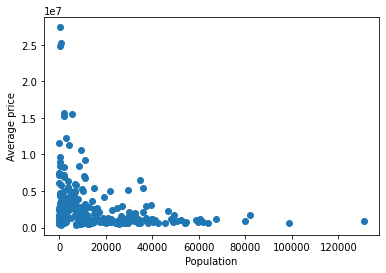

In [17]:
# plot of population against average price in the subzone
xpoints = df2["population"]
ypoints = df2["price_average"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Population')
plt.ylabel('Average price')
plt.show()

Insights from this plot:
* Price of a property on a densely populated area > price of a property in a less populated area.
* It can be inferred that people tend to buy houses in highly populated areas. It maybe due to a need for community and socializing. 



### Population in a Subzone Vs Area of the Subzone

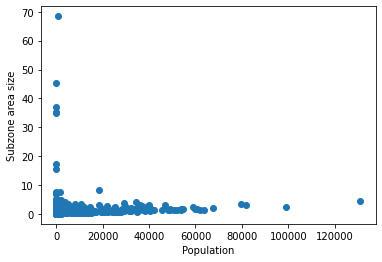

In [82]:
# plot of population against average price in the subzone
xpoints = df2["population"]
ypoints = df2["area_size"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Population')
plt.ylabel('Subzone area size')
plt.show()

Insights from the plot:
* Population on Subzones with larger land areas < population on subzones with lesser land area.
* It can be inferred that denser areas are split into smaller subzone areas to develop them individually well and cater for the denser population. 
* Also, can be concluded that the Singapore government might split subzones which currently have lesser population and bigger area into smaller ones as they get developed and populated over time as well. 

### Property Price Vs Population of the Subzone The Property is Located In 

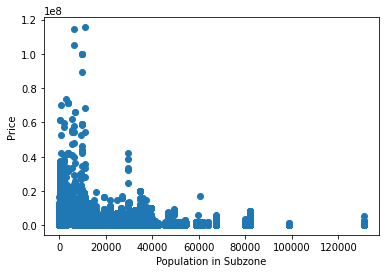

In [83]:
xpoints = df["subzone_pop"]
ypoints = df["price"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Population in Subzone')
plt.ylabel('Price')

plt.show()

Insights from the plot:

* There are only a very few listed properties in subzones with higher population ranges equaling or greater than 80000. This might be because that the people in these areas are settled for long and also the properties might be old making it hard to find a property to purchase in them. 
* Singapore government could also ensure that there are always enough non-expensive properties present in lesser populated areas as shown in the plot so that there it forms a natural way to spread out the population.


### Distance to nearest (within 1km) community center against price of property

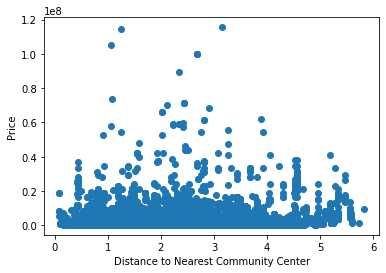

In [84]:
xpoints = df["dist_2_nearest_cc"]
ypoints = df["price"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Distance to Nearest Community Center')
plt.ylabel('Price')
plt.show()

Insights from the plot:
* Distance to the community centre doesnt really change the price significantly.
* However, it can be seen that the highly priced properties are neither close nor far from the community centres ranging from 1km to 4km in the total range of 0 to 6kms


### Distance to nearest (within 1km) MRT station against price of property

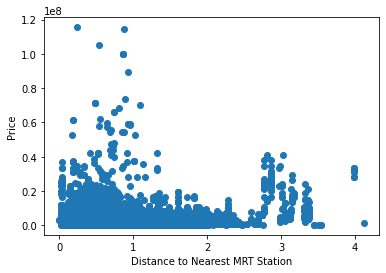

In [85]:
xpoints = df["dist_2_nearest_mrt"]
ypoints = df["price"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Distance to Nearest MRT Station')
plt.ylabel('Price')

plt.show()

Insights from the plot:
* Distance to the nearest MRT station has an influence on the price of the property.
* All highly priced properties greater than 60,000,000 is located within a distance of less than 1.5km from a MRT station.

### Distance to nearest (within 1km) Primary school against price of property

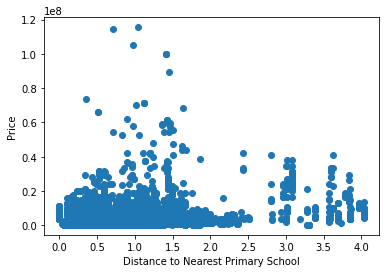

In [86]:
xpoints = df["dist_2_nearest_ps"]
ypoints = df["price"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Distance to Nearest Primary School')
plt.ylabel('Price')

plt.show()

Insights from the plot:
* Distance to the nearest primary school has an influence on the price of the property.
* All highly priced properties greater than 60,000,000 is located within a distance of around 1.5KM from a primary school.

### Distance to nearest (within 1km) Secondary school against price of property

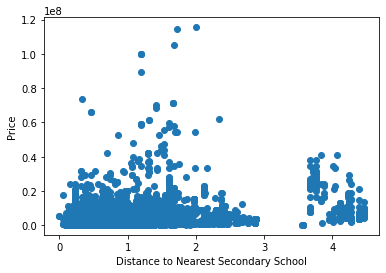

In [87]:
xpoints = df["dist_2_nearest_ss"]
ypoints = df["price"]


plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Distance to Nearest Secondary School')
plt.ylabel('Price')

plt.show()

Insights from the plot:
* Distance to the nearest secondary school has an influence on the price of the property.
* All highly priced properties greater than 60,000,000 is located within a distance of around 2KM from a secondary school.

### Distance to nearest (within 1km) shopping mall against price of property

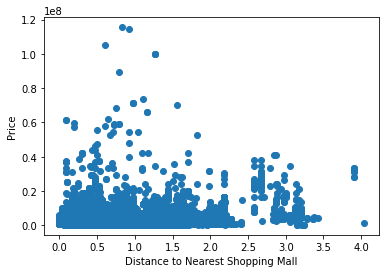

In [88]:
xpoints = df["dist_2_nearest_sm"]
ypoints = df["price"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Distance to Nearest Shopping Mall')
plt.ylabel('Price')

plt.show()

Insights from the plot:
* Distance to the nearest shopping mall has an influence on the price of the property.
* All highly priced properties greater than 60,000,000 is located within a distance of around 1.5KM from a shopping mall.

There are no major differences among these plots of price vs distance to nearest Infrastructure. The prices of properties do change accordingly based on the distance of nearest infrastructure. But still there is not a strong relavance to the distance and it could be attributed to the following reasons.

* Singapore is a small island, hence making the whole of it accessible in a rather short amount of time from anywhere within it if you have a personal vehicle, thus making the location of public infrastructures almost irrelevant to you.
* The public transport is system in Singapore is affordable and spans the whole Island. This also alleviates the need to be close to a public infrastructure, since it would be reachable in little or no time with public transport. In fact most people in Singapore prefer not to own personal vehicles because of this, aside from affordability issues. 
* Public infrastructures in Singapore are relatively evenly located. This means all planning areas/subzones usually have infrastructures like MRT, Primary School, Secondary, School, etc. 

### Plots of number of nearest infrastructure against property price

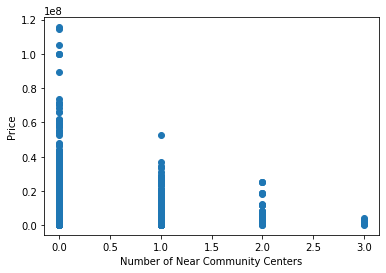

In [90]:
xpoints = df["nearest_cc_count"]
ypoints = df["price"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Number of Near Community Centers')
plt.ylabel('Price')

plt.show()

Insights from the plot:
* Most housing has zero community centers near them. However, the ones that do have community centers near are relatively lower in price. 
* All housing above SGD 60,000,000 have zero community centers near them, which shows some effect on the prices. Houses costing less than SGD 40,000,000 have 2 or more community centers near them. 

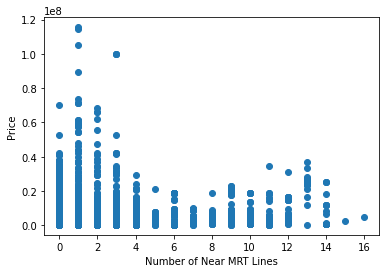

In [91]:
xpoints = df["nearest_mrt_count"]
ypoints = df["price"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Number of Near MRT Lines')
plt.ylabel('Price')

plt.show()

Insights from the plot:

* Properties with no MRT station near them cost less than SGD 80,000,000, while properties with 1 MRT cost even as much as the maximum price in the dataset.
* However properties with 3 MRT stations or more cost less than SGD 60,000,000

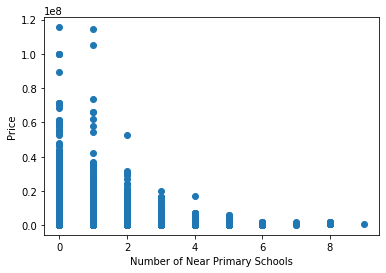

In [92]:
xpoints = df["nearest_ps_count"]
ypoints = df["price"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Number of Near Primary Schools')
plt.ylabel('Price')

plt.show()

Insights from the plot:
* Properties with zero primary schools are represented a lot in our data. This may mean people with no children or commercial properties. However, properties with four primary schools or more cost less than SGD 40,000,000 with an exception. 
* Schools with one primary school have a range of prices from lowest price to highest price represented in our data. 

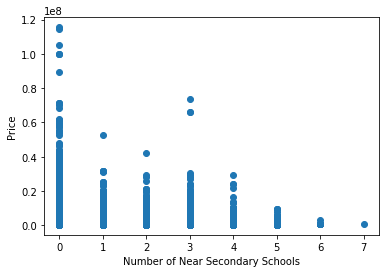

In [93]:
xpoints = df["nearest_ss_count"]
ypoints = df["price"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Number of Near Secondary Schools')
plt.ylabel('Price')

plt.show()

Insights from the plot:
* The higher the number of secondary schools near a property, the lower the price. Properties with zero secondary schools are represented a lot in our data. This may mean people with no children or commercial properties. 
* Properties with one secondary school or more cost less than SGD 40,000,000 with only 5 exceptions. 

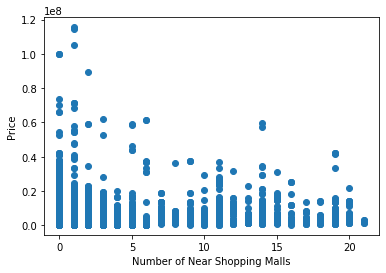

In [94]:
ypoints = df["price"]
xpoints = df["nearest_sm_count"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Number of Near Shopping Malls')
plt.ylabel('Price')

plt.show()

Insights from the plot:
* Just like the previous infrastructures, there are properties with zero shopping malls near them and the reason/insight for this is already explained above. 
* However, an even more interesting fact here is the amount of shopping malls in Singapore are a lot. And the price of properties are less than SGD 80,000,000 for properties having one shopping mall or more near them with only 3 outliers for one shopping mall and one outlier for two shopping malls. 

### Price vs Depreciation

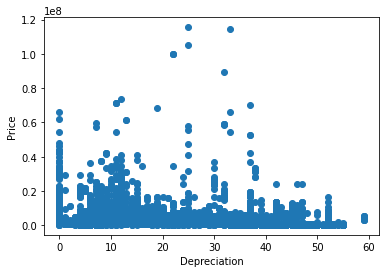

In [95]:
xpoints = df["depreciation"]
ypoints = df["price"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Depreciation')
plt.ylabel('Price')

plt.show()

Insights from the plot:
* More properties are represented where depreciation is less than 50 and the price is below SGD 80,000,000. Highly depreciated (more than 50) properties are few and cost very low, i.e., less than SGD 20,000,000.

### Number of beds/baths vs Price

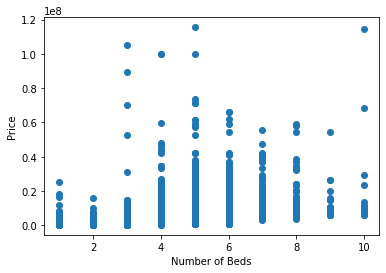

In [96]:
xpoints = df["num_beds"]
ypoints = df["price"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Number of Beds')
plt.ylabel('Price')

plt.show()

Insights from the plot:
* Some properties with the same number of beds cost higher while the others with same number of beds cost lower. This might be due to the different kinds of properties in Singapore, i.e. Condos, HDBs, etc. 
* However, properties with only two beds or less cost less than SGD 20,000,000 with only one outlier, which is also very close to the cost. This is largely expected. 

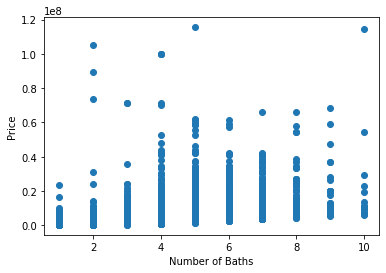

In [98]:
xpoints = df["num_baths"]
ypoints = df["price"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Number of Baths')
plt.ylabel('Price')

plt.show()

Insights from the plot:
* Some properties with the same number of baths cost higher while the others with same number of baths cost lower. This might be due to the different kinds of properties in Singapore, i.e. Condos, HDBs, etc. 
* The insight is very similar to number of beds.

# Correlation matrix

In [99]:
df.corr()


,num_beds,num_baths,size_sqft,price,depreciation,bungalow,condo,corner,hdb,landed,...,dist_2_nearest_cc,nearest_cc_count,dist_2_nearest_mrt,nearest_mrt_count,dist_2_nearest_ps,nearest_ps_count,dist_2_nearest_ss,nearest_ss_count,dist_2_nearest_sm,nearest_sm_count
num_beds,1.000000,0.840305,0.720466,0.499771,0.076044,0.392712,-0.345854,0.417280,-0.096077,0.126275,...,0.154127,-0.096637,0.196685,-0.179568,0.061315,-0.005072,0.123158,0.011435,0.178415,-0.127900
num_baths,0.840305,1.000000,0.792384,0.597969,-0.041205,0.437145,-0.206361,0.457585,-0.294063,0.155285,...,0.131009,-0.068890,0.176727,-0.099246,0.181694,-0.161289,0.235497,-0.085908,0.203835,-0.056836
size_sqft,0.720466,0.792384,1.000000,0.724930,0.054354,0.622891,-0.319484,0.448572,-0.222160,0.112127,...,0.158554,-0.057083,0.218811,-0.098719,0.235459,-0.172038,0.309878,-0.105994,0.248238,-0.084116
price,0.499771,0.597969,0.724930,1.000000,-0.086282,0.582181,-0.052917,0.232224,-0.330492,0.031327,...,0.115102,-0.042427,0.119771,0.034300,0.327182,-0.282868,0.357646,-0.187101,0.199653,0.062391
depreciation,0.076044,-0.041205,0.054354,-0.086282,1.000000,0.052654,-0.631426,0.032941,0.628920,-0.031374,...,0.025435,0.037139,0.054147,-0.141584,-0.174131,0.241616,-0.111769,0.155801,0.041093,-0.129419
bungalow,0.392712,0.437145,0.622891,0.582181,0.052654,1.000000,-0.219066,-0.051291,-0.132923,-0.020373,...,0.118544,-0.032998,0.210728,-0.066040,0.203985,-0.121858,0.284228,-0.116490,0.223142,-0.082329
condo,-0.345854,-0.206361,-0.319484,-0.052917,-0.631426,-0.219066,1.000000,-0.288822,-0.748493,-0.114723,...,-0.090843,0.028335,-0.146681,0.261940,0.228834,-0.320166,0.130486,-0.194833,-0.044784,0.227915
corner,0.417280,0.457585,0.448572,0.232224,0.032941,-0.051291,-0.288822,1.000000,-0.175249,-0.026861,...,0.042564,-0.035948,0.067670,-0.078724,0.020125,-0.089622,0.058383,-0.002519,0.102681,-0.094347
hdb,-0.096077,-0.294063,-0.222160,-0.330492,0.628920,-0.132923,-0.748493,-0.175249,1.000000,-0.069611,...,0.015323,0.002399,0.019043,-0.188160,-0.347624,0.462798,-0.296733,0.266517,-0.137403,-0.139731
landed,0.126275,0.155285,0.112127,0.031327,-0.031374,-0.020373,-0.114723,-0.026861,-0.069611,1.000000,...,0.013251,-0.000363,0.021218,-0.040245,0.026359,-0.052254,0.019507,-0.001118,0.067608,-0.036045


In [ ]:
df.drop('subzone_pop_density', axis=1, inplace=True)

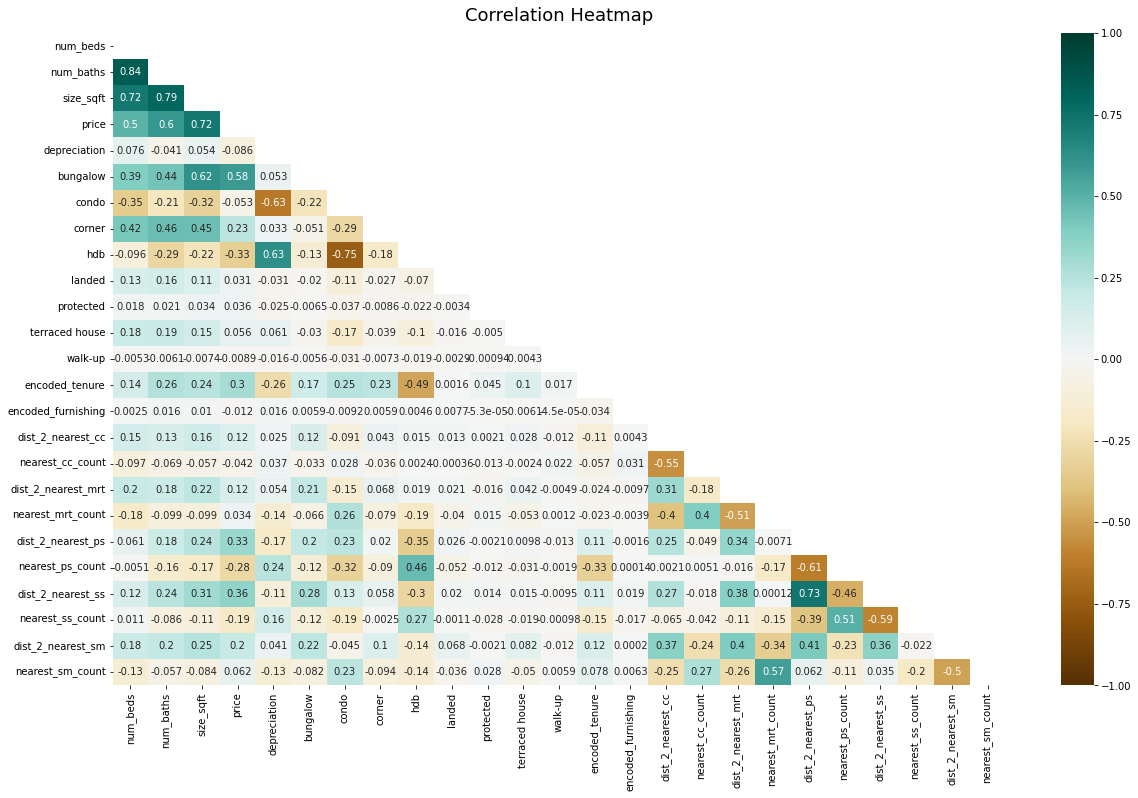

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 12))

mask = np.triu(np.ones_like(df.corr(), dtype=bool))

heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);


Insights from the correlation matrix:
* Number of beds, number of baths, size in sqft and price of the property are all highly positively correlated to each other. And property type of bungalow and corner houses are also highly positively correlated with it as well, which is understandable as they would be large in size with more rooms and higher price. While condo and HDB are negatively correlated to them which says that they would be opposite property types of bungalow and corner houses in this aspect.
* Condo is negatively correlated in data with depreciation and hdb is positively correlated which provides the insight that most of the condo properties are new in Singapore while HDB ones are old.
* Tenure of a property is negatively correlated with HDB which explains how the Singapore government governs the tenure of HDB to be lower while it is positively correlated with the rest of the property types.
* Number of nearest community centers is negatively correlated with the distance of the nearest community center which shows that the distance increases as more community centers are within the distance of 1 KM for a property. Similar correlation is seen for all infrastructure across Singapore which is number of nearest MRTs is negatively correlated with distance of nearest MRT, number of nearest shopping malls is negatively correlated with distance of nearest shopping mall, number of nearest schools(primary or secondary) is negatively correlated with distance of nearest schools(primary or secondary). This is a healthier spread across Singapore for utilisation and government could use this data to maintain the same when a new facility is planned for.
* As explained in all plots above, it is seen that price is positively correlated with the distance of all kinds of infrastructure across Singapore.


### THANK YOU